#0. Pasos previos
## Importar librerías

In [29]:
# 1. Importación de librerías
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#Importamos el modelo para español porque sino todo explota
!python -m spacy download es_core_news_md
import spacy
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import LinearSVC #Segundo modelo de prueba
from sklearn.tree import DecisionTreeClassifier #Tercer modelo de prueba
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 11.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1. Entendimiento y preparación de los datos

## 1.1 Perfilamiento y análisis de la calidad de los datos.

### Carga de datos

In [30]:
#Carga de los datos
data = pd.read_excel("Datos_proyecto.xlsx")  # Ajusta nombre si es diferente
print(data.head())

                                              textos  labels
0  "Aprendizaje" y "educación" se consideran sinó...       4
1  Para los niños más pequeños (bebés y niños peq...       4
2  Además, la formación de especialistas en medic...       3
3  En los países de la OCDE se tiende a pasar de ...       4
4  Este grupo se centró en las personas que padec...       3


In [31]:
# Ver información y tipado de data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


### Análisis de calidad de los datos

Para el análisis de calidad de los datos, miraremos si hay valores nulos en alguno de los dos campos. Igualmente, nos interesa mirar si hay filas duplicadas. Un duplicado correspondería a dos textos iguales pero con labels distintos. Igualmente, buscamos detectar si hay textos muy cortos (menores a 10 caracteres).

In [32]:
# Valores nulos por columna
print("Valores nulos:\n", data.isnull().sum())

# Filas duplicadas
print("\nNúmero de filas duplicadas:", data.duplicated().sum())

# Vemos si un mismo texto tiene más de un label asociado
duplicados_conflictivos = data.groupby("textos")["labels"].nunique()
conflictivos = duplicados_conflictivos[duplicados_conflictivos > 1]

print(f"Número de textos con más de un label distinto: {len(conflictivos)}")
print("Ejemplos:\n", data[data["textos"].isin(conflictivos.index)].head(10))

# Valores únicos de labels
print("\nLabels únicos:", data["labels"].unique())
print("Distribución de labels:\n", data["labels"].value_counts())

# Longitud de los textos
data["longitud_texto"] = data["textos"].astype(str).apply(len)

print("\nEstadísticas de longitud de textos:")
print(data["longitud_texto"].describe())

# Detectar textos muy cortos
print("\nTextos con menos de 10 caracteres:")
print(data[data["longitud_texto"] < 10].head())


Valores nulos:
 textos    0
labels    0
dtype: int64

Número de filas duplicadas: 0
Número de textos con más de un label distinto: 0
Ejemplos:
 Empty DataFrame
Columns: [textos, labels]
Index: []

Labels únicos: [4 3 1]
Distribución de labels:
 labels
4    1025
3     894
1     505
Name: count, dtype: int64

Estadísticas de longitud de textos:
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud_texto, dtype: float64

Textos con menos de 10 caracteres:
Empty DataFrame
Columns: [textos, labels, longitud_texto]
Index: []


Vemos que no hay problemas relacionados a valores nulos en los datos, textos duplicados (0 y 0 respectivamente), o textos demasiado cortos (el texto más corto tiene 303 caracteres, que puede corresponder a varias docenas de palabras). Con esto, decimos que no hay problemas significativos en la calidad de los datos.

Ahora, observaremos cuántos registros hay por cada label (tipo de objetivo) en un gráfico de barras.

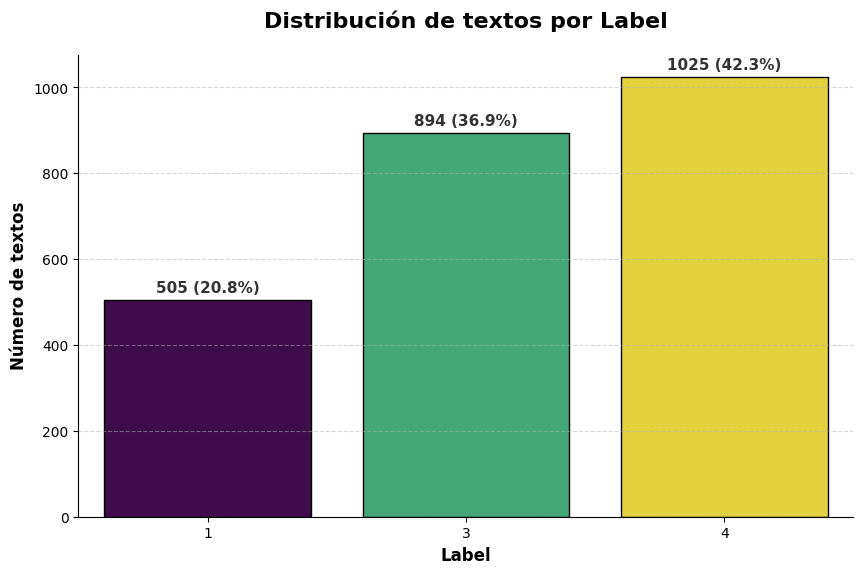

In [33]:
# Conteos
label_counts = data["labels"].value_counts().sort_index()
total = label_counts.sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    palette="viridis",
    edgecolor="black",
    legend = False
)

# Añadir anotaciones en cada barra
for p, count in zip(ax.patches, label_counts.values):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2.,   # centro de la barra
        height + 10,                    # un poquito encima
        f"{count} ({count/total:.1%})", # valor + porcentaje
        ha="center", va="bottom",
        fontsize=11, fontweight="bold", color="#333"
    )

# Título y estilo
plt.title("Distribución de textos por Label", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Label", fontsize=12, fontweight="bold")
plt.ylabel("Número de textos", fontsize=12, fontweight="bold")
sns.despine()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Se observa que la moda para los datos es el label 4. El label 3 se acerca más a 1/3 de los datos, que correspondería a una división totalmente equitativa entre los labels. Solo el 20% de los datos cuentan con el label 1. Más adelante se abordarán posibles opciones en busca de posiblemente prevenir sesgos que vienen de que un tipo de dato sea más común que otro.

Veamos, a través de un histograma y un boxplot, cómo se distribuye la longitud de los textos dados.

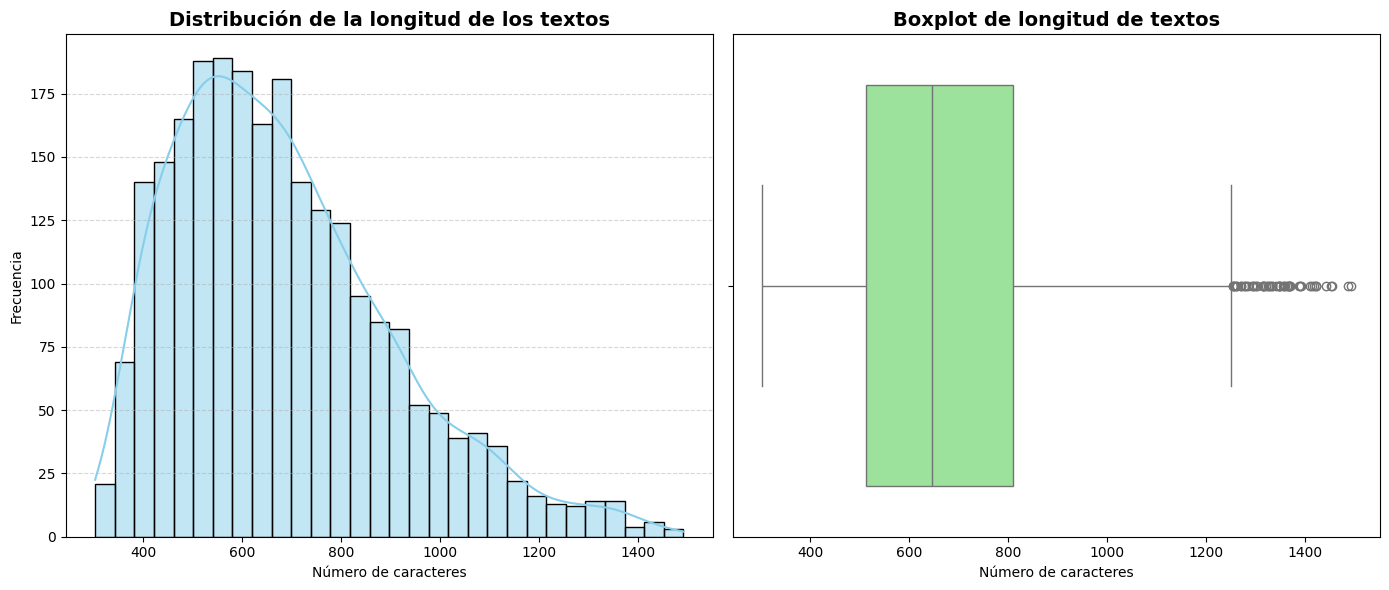

In [34]:
# Asegurarnos de tener la columna de longitud
data["longitud_texto"] = data["textos"].astype(str).apply(len)

plt.figure(figsize=(14,6))

# Histograma
plt.subplot(1,2,1)
sns.histplot(data["longitud_texto"], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Distribución de la longitud de los textos", fontsize=14, fontweight="bold")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=data["longitud_texto"], color="lightgreen")
plt.title("Boxplot de longitud de textos", fontsize=14, fontweight="bold")
plt.xlabel("Número de caracteres")

plt.tight_layout()
plt.show()

## 1.2 Tratamiento de los datos

Para preparar los datos se realizó un proceso de **preprocesamiento de texto en español**. Inicialmente, aplicamos **lematización** con la librería spaCy, con el fin de reducir cada palabra a su forma base y eliminar variaciones morfológicas (por ejemplo, plurales o conjugaciones verbales). Esto permite un mejor agrupamiento semántico de los términos. Posteriormente, se utilizó la técnica de **TF-IDF (Term Frequency - Inverse Document Frequency)** para representar cada texto como un vector numérico. Este método pondera las palabras según su frecuencia en cada documento y su relevancia en todo el corpus, de manera que aquellas que aparecen en muchos textos comunes (como stopwords) pierden importancia, mientras que las más representativas ganan peso en la matriz de características.


In [35]:
# Para lematización en español
nlp = spacy.load("es_core_news_md")


#Preprocesamiento: lematización
def lemmatize_text(text):
    doc = nlp(str(text))
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop])

data["textos_proc"] = data["textos"].apply(lemmatize_text)

# 4. Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["textos_proc"])
y = data["labels"]

#Las variables 'X' y 'Y' las usaremos más adelante en el entrenamiento de los modelos
# PARA EL BONO EMBEDIDO
X_raw = data["textos"]   # Solo los string puros

Toca verificar cuantos datos hay en el entrenamiento de cada clase para que no haya métricas sesgadas.

Ahora, sería interesante ver, por cada uno de los distintos objetivos de desarrollo sostenible (labels), cuáles lemas ('palabras' resultantes después de hacer agrupación por lematización) son los más comunees.

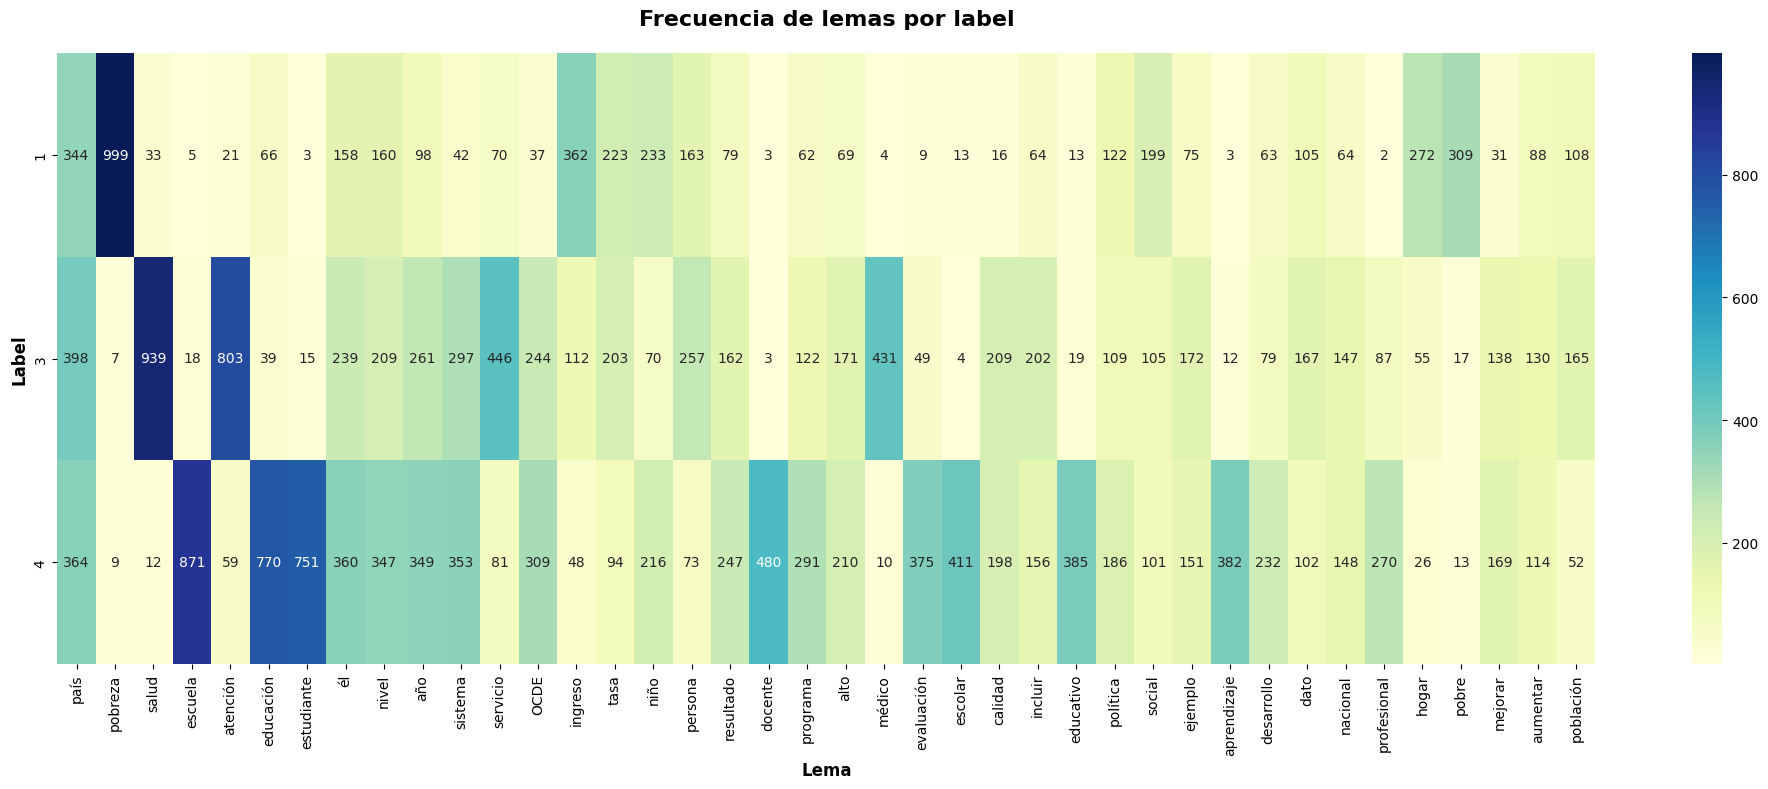

In [36]:
# Separar tokens por label
lemmatized_by_label = data.groupby("labels")["textos_proc"].apply(lambda x: " ".join(x)).reset_index()

# Contar frecuencias por label
freq_dicts = {}
for _, row in lemmatized_by_label.iterrows():
    label = row["labels"]
    tokens = row["textos_proc"].split()
    freq_dicts[label] = Counter(tokens)

# Unir en un DataFrame
freq_df = pd.DataFrame(freq_dicts).fillna(0).astype(int).T  # labels como filas
# Tomamos los N lemas más frecuentes globalmente
N = 40
top_words = freq_df.sum(axis=0).sort_values(ascending=False).head(N).index
freq_df_top = freq_df[top_words]

# Dibujar heatmap
plt.figure(figsize=(20,8))
sns.heatmap(freq_df_top, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Frecuencia de lemas por label", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Lema", fontsize=12, fontweight="bold")
plt.ylabel("Label", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

El heatmap de frecuencias de lemas por objetivo permite identificar qué temas y vocabulario están más asociados a cada label. Por ejemplo, en el label 1 aparecen con fuerza términos vinculados a salud como “salud” y “médico”, lo que sugiere que este objetivo se relaciona principalmente con problemáticas sanitarias. En el label 3 destacan lemas como “escuela”, “estudiante” y “programa”, lo cual refleja una fuerte conexión con el ámbito de la educación. Por su parte, el label 4 muestra frecuencias altas en palabras como “docente”, “evaluación” y “aprendizaje”, indicando un foco en calidad educativa y formación profesional.

##1.3 Partición de los datos

Esta partición se realiza en tres set de datos, en la sección de "Selección del modelo" se justificará la toma de esta decisión.

In [37]:
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #70% entrenamiento

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=1) # 0.3 x 1/3 = 10% para validación


# 2. Modelado y Evaluación

## 2.1 Modelos
Vamos a probar tres modelos con el fin de evaluar cuál es el mejor para nuestro negocio.

### 2.1.1 K-Vecinos (Juan David Torres Albarracín)

Una vez vectorizados los textos, se entrenó un **modelo de clasificación supervisada basado en K-Nearest Neighbors (KNN)**. Para encontrar la mejor configuración del clasificador, se implementó un **GridSearchCV con validación cruzada de 10 particiones**, explorando diferentes valores de hiperparámetros como el número de vecinos (`n_neighbors`) y la métrica de distancia (`euclidean`, `manhattan`, `cosine`). El criterio de selección fue el **F1-macro**, que evalúa de forma balanceada el desempeño en todas las clases, incluso cuando existe desbalance en las etiquetas. Finalmente, se evaluó el modelo óptimo en el conjunto de prueba, analizando métricas como **exactitud, precisión, recall y F1-score**, así como la **matriz de confusión** para interpretar los resultados de la clasificación.


Ahora, definimos los parámetros que explorará cambiar el grid para encontrar un mejor modelo. En este caso se jugará con los tipos de distancia y el número de vecinos.

In [38]:

# Definición del modelo KNN + GridSearch
param_grid = {
    "n_neighbors": list(range(1, 21)),
    "metric": ["euclidean", "manhattan", "cosine"]
}



Usamos una instancia de KFold para hacer validación cruzada (cv) más adelante. Se harán 10 particiones aleatorias de los datos.

In [39]:
cv = KFold(n_splits=10, shuffle=True, random_state=0)

Corremos el modelo el clasificador KNN usando el grid de parámetros y mecanismo de verificación cruzada definido anteriormente. En este caso, queremos un análisis balanceado de los datos, por lo que el mejor modelo se escojerá basado en su puntaje F1.

In [40]:
knn = KNeighborsClassifier()

# 1. Ajustamos el modelo con GridSearchCV
grid = GridSearchCV(knn, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)


Analizaremos gráficamente los distintos puntajes obtenidos para cada forma de medir distancia con un número K de vecinos más cercanos (los parámetros que variaron en el grid search).

Pivot (k x metric) — primeras filas:
 metric    cosine  euclidean  manhattan
k                                     
1       0.916660   0.916660   0.419400
2       0.900408   0.900408   0.396660
3       0.937201   0.937201   0.426384
4       0.933012   0.933012   0.469135
5       0.948346   0.948346   0.577883
6       0.948577   0.948577   0.497794
7       0.952989   0.952989   0.521638
8       0.952257   0.952257   0.519036
9       0.961590   0.961590   0.518100
10      0.960874   0.960874   0.513738

Mejores hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 13}
Nota: 'euclidean' y 'cosine' tienen valores idénticos. En el gráfico se hará un breve desplazamiento para que se pueda ver


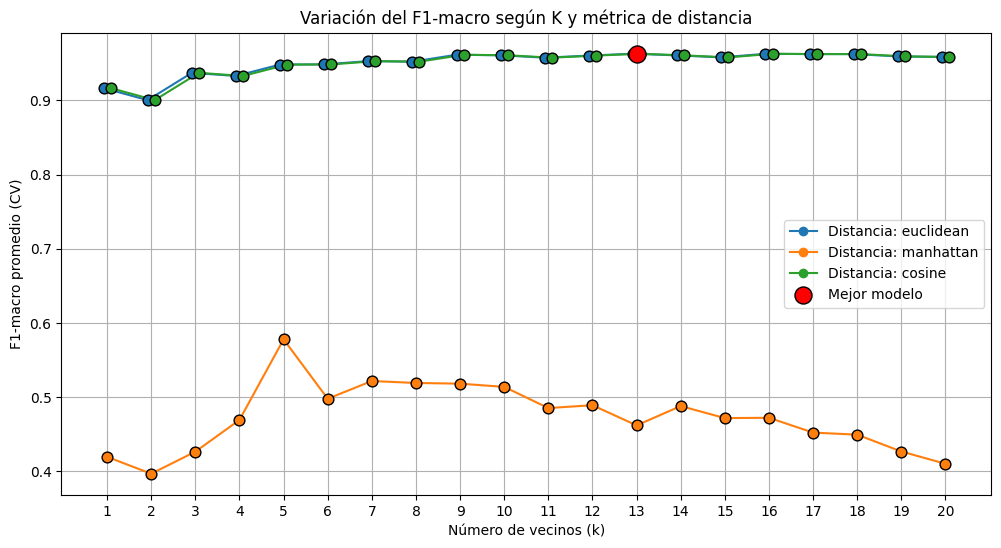

In [41]:

# ESTANDARIZAMOS nombres: si sklearn devuelve 'minkowski', usar param_p cuando exista,
# pero también aceptar que param_metric ya puede venir como 'euclidean'/'manhattan'/'cosine'.
# BÁSICAMENTE CON ESTO NO EXPLOTA LA GRÁFICA POR LAS CONFUSIONES EN EL LABEL
def normalize_metric(row):
    m = str(row["param_metric"])
    # si existe 'param_p' en results, usarlo para distinguir minkowski
    if m == "minkowski" and "param_p" in results.columns:
        p = row.get("param_p", None)
        if p == 1:
            return "manhattan"
        elif p == 2:
            return "euclidean"
        else:
            return f"minkowski_p{p}"
    return m
results_graph = results.copy()
results_graph["metric_norm"] = results.apply(normalize_metric, axis=1)
# asegurarnos de que n_neighbors sea int (a veces es objeto)
results_graph["n_neighbors"] = results["param_n_neighbors"].astype(int)
results_summary = results_graph[["metric_norm", "n_neighbors", "mean_test_score"]].copy()
results_summary.columns = ["metric", "k", "mean_test"]

# Pivot: filas = k, columnas = metric, valores = mean_test
pivot = results_summary.pivot(index="k", columns="metric", values="mean_test")
pivot = pivot.sort_index()  # ordenar por k
print("Pivot (k x metric) — primeras filas:\n", pivot.head(10))

# --- 2) identificamos el mejor modelo
best_params = grid.best_params_
print("\nMejores hiperparámetros:", best_params)
# normalizar nombre del mejor metric (en caso de 'minkowski' etc)
best_metric = ("euclidean" if best_params.get("metric") == "minkowski" else best_params.get("metric"))
best_k = int(best_params.get("n_neighbors"))
# obtenemos el best_score
try:
    best_score = float(pivot.loc[best_k, best_metric])
except Exception:
    # fallback
    best_score = float(results_summary[(results_summary["metric"]==best_metric)&(results_summary["k"]==best_k)]["mean_test"].iloc[0])

# comprobar solapamiento euclidean vs cosine (como los datos están estandarizados, pueden ser muy similares)
if "euclidean" in pivot.columns and "cosine" in pivot.columns:
    same = np.allclose(pivot["euclidean"].fillna(np.nan), pivot["cosine"].fillna(np.nan), equal_nan=True)
    if same:
        print("Nota: 'euclidean' y 'cosine' tienen valores idénticos. En el gráfico se hará un breve desplazamiento para que se pueda ver")

#  plotting (con ligero desplazamiento para ver puntos superpuestos).

plt.figure(figsize=(12,6))

metrics = [m for m in ["euclidean","manhattan","cosine"] if m in pivot.columns]
colors = {"euclidean":"tab:blue","manhattan":"tab:orange","cosine":"tab:green"}

for i, metric in enumerate(metrics):
    y_graph = pivot[metric].values
    x_graph = pivot.index.values.astype(float)
    jitter = (i - (len(metrics)-1)/2) * 0.08  # pequeño desplazamiento horizontal
    xj = x_graph + jitter
    plt.plot(xj, y_graph, marker="o", label=f"Distancia: {metric}", color=colors.get(metric))
    plt.scatter(xj, y_graph, s=60, color=colors.get(metric), edgecolor="k", zorder=4)

# marcar mejor modelo
plt.scatter([best_k], [best_score], color="red", s=150, label="Mejor modelo", zorder=6, edgecolor="k")
plt.xticks(pivot.index)
plt.xlabel("Número de vecinos (k)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variación del F1-macro según K y métrica de distancia")
plt.grid(True)
plt.legend()
plt.show()


El programa nos muestra a este como el mejor modelo:
```
Mejores hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 17}
```

Podemos ver que las distancias euclideanas y coseno tuvieron resultados muy parecidos, mientras la Manhattan tuvo resultados considerablemente peores. Para la distancia euclideana (marcada como la mejor por los datos obtenidos) se obtuvo el mejor puntaje F1-macro con 17 vecinos. Sin embargo, pareciera ser bastante constante el puntaje F1 en el rango de 13-20.

Ahora veremos la matriz de confusión del mejor modelo escogido.


--- Desempeño del mejor modelo ---
F1-macro (Entrenamiento): 0.9749
F1-macro (Test): 0.9574
F2-score Train: 0.9743994930821462
F2-score Test: 0.9580904603906392

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           1       0.93      0.95      0.94       149
           3       0.97      0.96      0.96       267
           4       0.97      0.97      0.97       312

    accuracy                           0.96       728
   macro avg       0.96      0.96      0.96       728
weighted avg       0.96      0.96      0.96       728



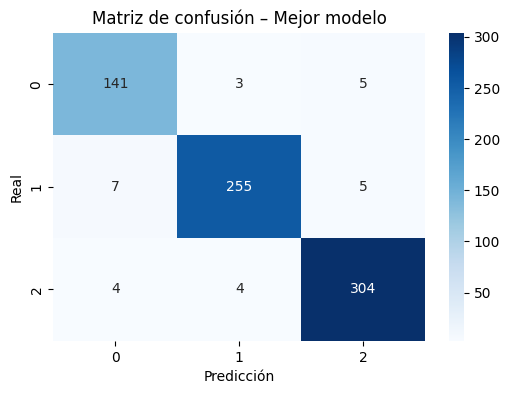

In [42]:

# evaluación final del mejor modelo (train / test)
best_knn = grid.best_estimator_

y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)
train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempeño del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
f2 = fbeta_score(y_train, y_pred_train, beta=2, average='macro')
print("F2-score Train:", f2)
f22 = fbeta_score(y_test, y_pred_test, beta=2, average='macro')
print("F2-score Test:", f22)
print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo")
plt.show()

Para todos los labels, se tienen altos niveles de precisión y recall (>90%). No obstante, para el label 1, se tiene un nivel de precisión menor comparado al 3 y 4. Esta ordinalidad coincide con el número de registros reportados en el análisis de datos. Es decir, los labels con más datos tienen, a su vez, mejores métricas.

Con el fin de corregir algún posible sesgo, se aplicará el método SMOTE y se compararán los resultados obtenidos. El código con SMOTE es el siguiente:

In [43]:
print("Distribución original de y_train:\n", y_train.value_counts())

# ------------------------------
# Definir pipeline con SMOTE + KNN
# ------------------------------
pipeline = Pipeline([
    ("smote", SMOTE(random_state=0, k_neighbors=5)),
    ("knn", KNeighborsClassifier())
])

# ------------------------------
# Hiperparámetros a buscar
# ------------------------------
param_grid = {
    "knn__n_neighbors": list(range(1, 21)),
    "knn__metric": ["euclidean", "manhattan", "cosine"]
}

cv = KFold(n_splits=10, shuffle=True, random_state=0)

# ------------------------------
# GridSearchCV
# ------------------------------
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)  # OJO: aquí SMOTE se aplica internamente solo en train


Distribución original de y_train:
 labels
4    472
3    421
1    237
Name: count, dtype: int64


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'cosine'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             return_train_score=True, scoring='f1_macro')

Ahora, armamos nuevamente un gráfico analizando las métricas para cada hiperparámetro.

Pivot (k x metric) — primeras filas:
 metric    cosine  euclidean  manhattan
k                                     
1       0.912249   0.576375   0.419400
2       0.895133   0.440562   0.396660
3       0.922053   0.491537   0.427774
4       0.912833   0.435083   0.474565
5       0.924803   0.455473   0.585744

Mejores hiperparámetros: {'knn__metric': 'cosine', 'knn__n_neighbors': 19}


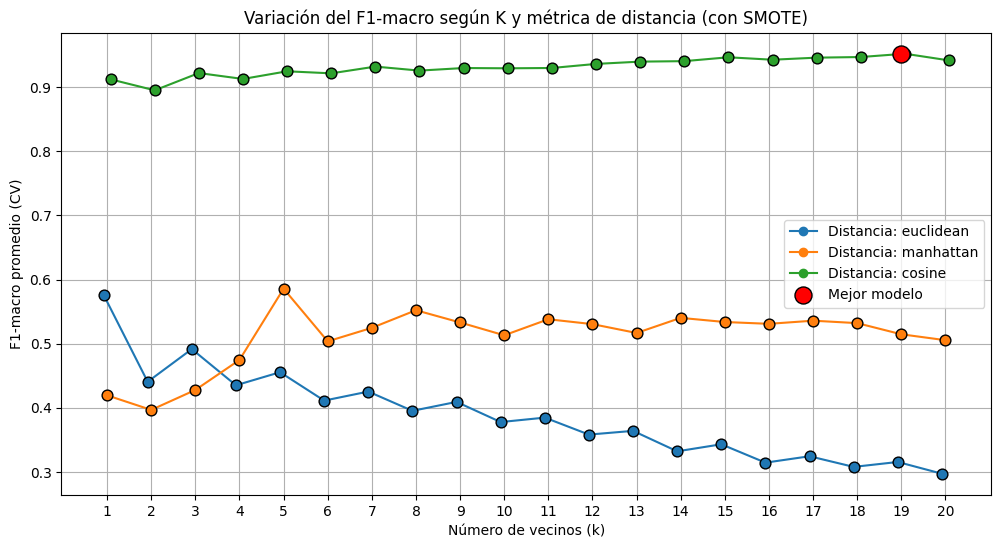

In [44]:
# ------------------------------
# Resultados
# ------------------------------
results = pd.DataFrame(grid.cv_results_)

# Normalizar nombres de métricas
def normalize_metric(row):
    m = str(row["param_knn__metric"])
    if m == "minkowski" and "param_knn__p" in results.columns:
        p = row.get("param_knn__p", None)
        if p == 1:
            return "manhattan"
        elif p == 2:
            return "euclidean"
        else:
            return f"minkowski_p{p}"
    return m

results["metric_norm"] = results.apply(normalize_metric, axis=1)
results["k"] = results["param_knn__n_neighbors"].astype(int)
results_summary = results[["metric_norm", "k", "mean_test_score"]].copy()
results_summary.columns = ["metric", "k", "mean_test"]

# Pivot para graficar
pivot = results_summary.pivot(index="k", columns="metric", values="mean_test")
pivot = pivot.sort_index()
print("Pivot (k x metric) — primeras filas:\n", pivot.head())

# ------------------------------
# Mejor modelo
# ------------------------------
best_params = grid.best_params_
print("\nMejores hiperparámetros:", best_params)

best_metric = best_params["knn__metric"]
best_k = int(best_params["knn__n_neighbors"])
best_score = float(
    results_summary[
        (results_summary["metric"] == best_metric) & (results_summary["k"] == best_k)
    ]["mean_test"].iloc[0]
)

# ------------------------------
# Gráfico comparativo
# ------------------------------
plt.figure(figsize=(12,6))
metrics = [m for m in ["euclidean","manhattan","cosine"] if m in pivot.columns]
colors = {"euclidean":"tab:blue","manhattan":"tab:orange","cosine":"tab:green"}

for i, metric in enumerate(metrics):
    y_vals = pivot[metric].values
    x_vals = pivot.index.values.astype(float)
    jitter = (i - (len(metrics)-1)/2) * 0.08
    xj = x_vals + jitter
    plt.plot(xj, y_vals, marker="o", label=f"Distancia: {metric}", color=colors.get(metric))
    plt.scatter(xj, y_vals, s=60, color=colors.get(metric), edgecolor="k", zorder=4)

# Resaltar mejor modelo
plt.scatter([best_k], [best_score], color="red", s=150, label="Mejor modelo", zorder=6, edgecolor="k")
plt.xticks(pivot.index)
plt.xlabel("Número de vecinos (k)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variación del F1-macro según K y métrica de distancia (con SMOTE)")
plt.grid(True)
plt.legend()
plt.show()


Esta vez, se obtuvo que este era el mejor modelo
```
Mejores hiperparámetros: {'knn__metric': 'cosine', 'knn__n_neighbors': 20}
```
Por otro lado, la distancia euclidiana empeoró sus resultados considerablemente.

Ahora, observemos la matriz de confusión, y las métricas para el modelo con mayor detalle.


--- Desempeño del mejor modelo (con SMOTE) ---
F1-macro (Entrenamiento): 0.9546
F1-macro (Test): 0.9395

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           1       0.84      0.99      0.91       149
           3       0.98      0.93      0.95       267
           4       0.98      0.94      0.96       312

    accuracy                           0.95       728
   macro avg       0.93      0.95      0.94       728
weighted avg       0.95      0.95      0.95       728



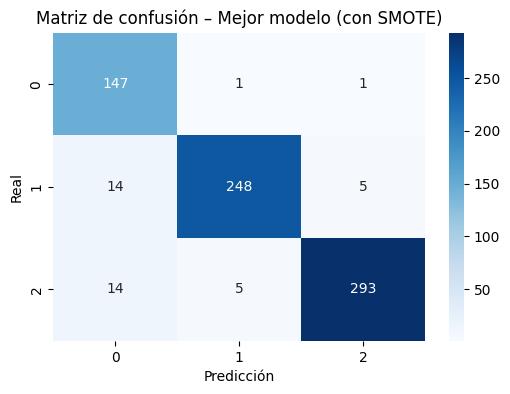

In [45]:
# ------------------------------
# Evaluación final en test
# ------------------------------
best_knn = grid.best_estimator_

y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempeño del mejor modelo (con SMOTE) ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo (con SMOTE)")
plt.show()

La aplicación de la técnica SMOTE buscaba mitigar el desbalance de clases presente en el conjunto de datos mediante la generación de instancias sintéticas para las clases minoritarias. No obstante, los resultados muestran que el desempeño del modelo disminuyó al incorporar este procedimiento, evidenciado en una reducción del puntaje F1-macro en el conjunto de prueba. Este fenómeno puede explicarse porque, si bien SMOTE equilibra la distribución de clases en el entrenamiento, las instancias generadas no siempre reflejan patrones reales de los datos, lo que introduce ruido y posibles solapamientos entre clases. En consecuencia, el modelo tiende a sobreajustarse a ejemplos artificiales, reduciendo su capacidad de generalización frente a datos auténticos.

En este contexto, los resultados sugieren que el desbalance de clases inicial no representaba un problema crítico para el desempeño del modelo. De hecho, el clasificador entrenado sin SMOTE alcanzó un F1-macro superior en el conjunto de prueba, indicando una mejor capacidad de generalización y mayor equilibrio entre precisión y exhaustividad en la clasificación real. Por lo tanto, se concluye que, para este caso particular, el modelo sin balanceo mediante SMOTE constituye la alternativa más adecuada, mientras que el experimento con oversampling aporta un insumo valioso para comprender el impacto del desbalance y descartar la necesidad de su corrección en este escenario.

### 2.1.2 Support Vector Machine - Angie Gutiérrez

En el tratamiento de datos los textos fueron transformados con TF-IDF, lo cual convierte las opiniones en puntos en un espacio enorme (cada palabra lematizada es una dimensión). Por lo tanto, se entrenó un **modelo de clasificación supervisado basado en SVM** que tiene como objetivo buscar una frontera (una línea, plano o hiperplano) que separe lo mejor posible esos puntos en función de la clase (En este caso ODS: 1, 3 o 4). Además, este intenta maximizar la distancia entre los puntos más cercanos de cada clase y la frontera → eso hace que generalice mejor en nuevos datos. Para este caso en particular, no se usa un SVM normal, si no un **LinearSVC que aplica un SVM lineal optimizado** para la clasificación de texto y evita un SVM con kernel no lineal que es mucho más lento (y es innecesario para este caso).

**Definición del modelo y parámetros a explorar:**

Primero, vamos a jugar con el hiperparámetro **C** que controla la regularización, cuando se usan valores pequeños el modelo es más simple, pero cuando se utilizan valores grandes lo hacen más flexible.

In [46]:
# Hiperparámetros a explorar
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

# Definimos la validación cruzada
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Clasificador base
svm = LinearSVC(random_state=0, max_iter=5000)

**Búsqueda de hiperparámetros con GridSearchCV**

Se usan 10 particiones de validación cruzada y el criterio F1-macro para equilibrar el desempeño en todas las clases.

In [47]:
# GridSearch con validación cruzada
grid = GridSearchCV(svm, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

# Resultados en DataFrame
results = pd.DataFrame(grid.cv_results_)

**Análisis gráfico de hiperparámetros**

Aquí vamos a observar cómo cambia el desempeño según el valor de C. Se eligió el que maximiza F1-macro que se puede evidenciar en el gráfico.

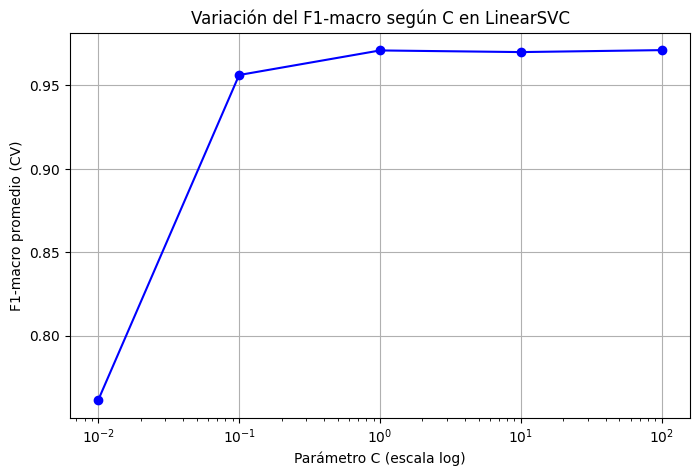

In [48]:
# Gráfica de F1-macro vs C
plt.figure(figsize=(8,5))
plt.plot(results["param_C"], results["mean_test_score"], marker="o", color="b")
plt.xscale("log")  # escala log para ver mejor C
plt.xlabel("Parámetro C (escala log)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variación del F1-macro según C en LinearSVC")
plt.grid(True)
plt.show()

**Selección del mejor modelo**

Se encontró que C=100 da el mejor resultado, balanceando precisión y recall. ⭐

In [49]:
# Mejor modelo encontrado
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Mejor F1-macro (CV):", best_score)

Mejores hiperparámetros: {'C': 100}
Mejor F1-macro (CV): 0.9711657329010548


**Evaluación en train y test**

Gracias a esta evaluación, podemos evidenciar que el F1-macro es casi idéntico en entrenamiento (1.00) y prueba (0.9785), lo cual indica una buena generalización. 👏

In [50]:
# Evaluación en train y test
best_svm = grid.best_estimator_
y_pred_train = best_svm.predict(X_train)
y_pred_test = best_svm.predict(X_test)

train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1 = f1_score(y_test, y_pred_test, average="macro")

print("\n--- Desempeño del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")

# Mostrar reporte de clasificación
print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test))



--- Desempeño del mejor modelo ---
F1-macro (Entrenamiento): 1.0000
F1-macro (Test): 0.9622

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       149
           3       0.97      0.96      0.96       267
           4       0.97      0.98      0.98       312

    accuracy                           0.97       728
   macro avg       0.96      0.96      0.96       728
weighted avg       0.97      0.97      0.97       728



**Matriz de confusión**

Gracias a la matriz podemos evidenciar los Falsos Positivos, Verdaderos Positivos, Falsos Negativos y Verdaderos Negativos.

Principalmente, notamos que hay unos pocos errores porque se confunde la ODS 1 (pobreza) con ODS 3 o 4.

Por otro lado, las clases ODS 3 y 4 se clasifican casi perfectas. 🧑

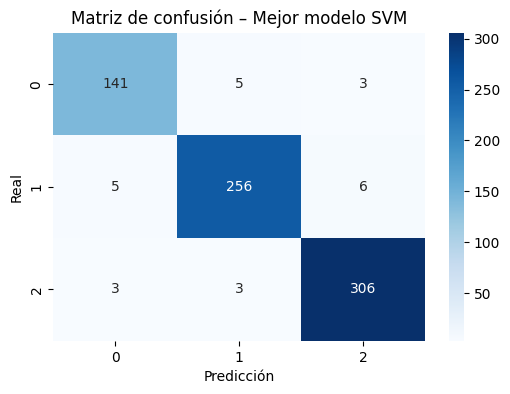

In [51]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo SVM")
plt.show()

**Extracción de las palabras más importantes que el SVM usa para decidir entre ODS**

Se muestran las 10 palabras más relevantes que el modelo usa para distinguir cada ODS.

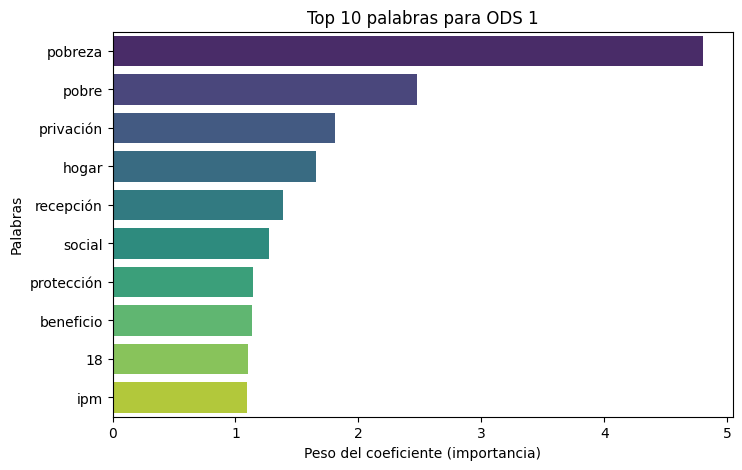

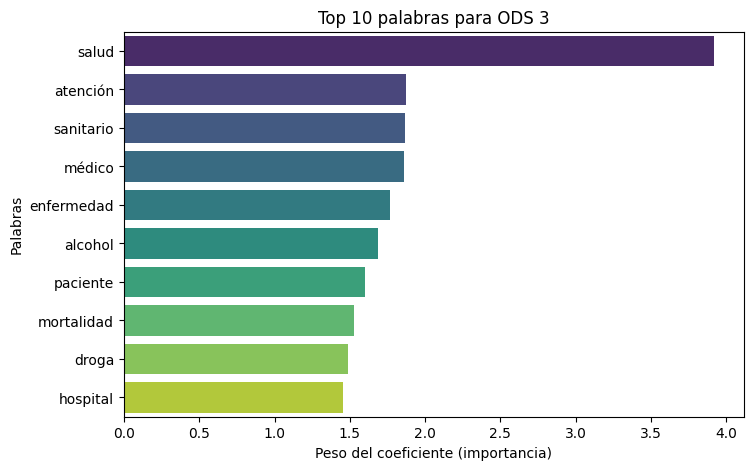

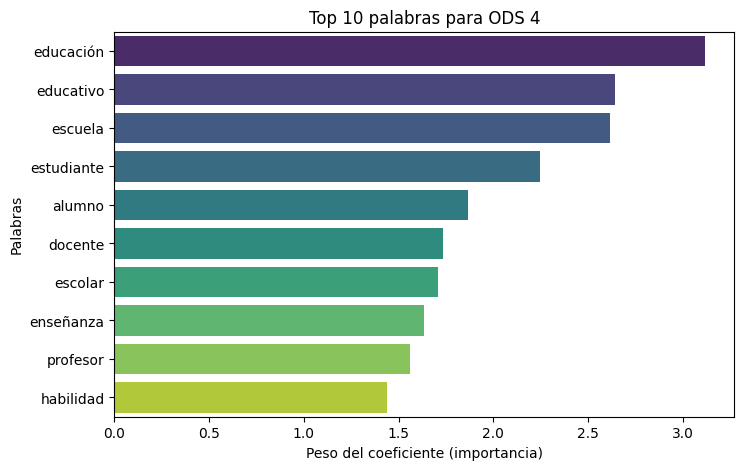

In [52]:
# Palabras del vectorizador
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = best_svm.coef_

def plot_top_words(coefs, feature_names, top_n=10):
    for i, class_label in enumerate(best_svm.classes_):
        top_indices = np.argsort(coefs[i])[-top_n:]
        top_features = [(feature_names[j], coefs[i][j]) for j in reversed(top_indices)]
        palabras, pesos = zip(*top_features)

        plt.figure(figsize=(8, 5))
        sns.barplot(x=pesos, y=palabras, hue=palabras, palette="viridis", dodge=False, legend=False)
        plt.title(f"Top {top_n} palabras para ODS {class_label}")
        plt.xlabel("Peso del coeficiente (importancia)")
        plt.ylabel("Palabras")
        plt.show()

plot_top_words(coefs, feature_names, top_n=10)

### Conclusiones del Support Vector Machine
* El desempeño por cada clase revela que en el ODS:

1. Pobreza: *precision=0.95, recall=0.95, f1=0.95*. Es decir, se pierden un pequeño número de casos por el recall pero es muy preciso.

3. Salud: *precision=0.97, recall=0.96, f1=0.96.* . Es decir, hay un gran equilibrio entre la precisión y la cobertura.

4. Educación: *precision=0.97, recall=0.98, f1=0.98.* . Es decir, se reconocen prácticamente todos los ejemplos gracias al recall.


* La matriz de confusión nos muestra que la mayoría de los errores ocurren al confundir ODS 1 con ODS 3 o 4, estos falsos positivos pueden surgir debido a que algunos textos de pobreza incluyen menciones a salud o educación. Por otro lado, ODS 3 y ODS 4 tienen casi clasificación perfecta. :D

* El modelo con C=100 logra desempeño casi perfecto en entrenamiento (F1=1.0), lo que indica que ajusta fuertemente a los datos.

* En prueba, mantiene un alto rendimiento (F1=0.962), aunque ligeramente menor, lo que refleja un pequeño grado de sobreajuste.


En términos generales, el clasificador SVM con C=100 es muy sólido y confiable, alcanzando un accuracy global del 97%.

### 2.1.3 Arboles de Decision - Kalia Gonzalez

Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mejor F1-macro (CV): 0.9306726915735293


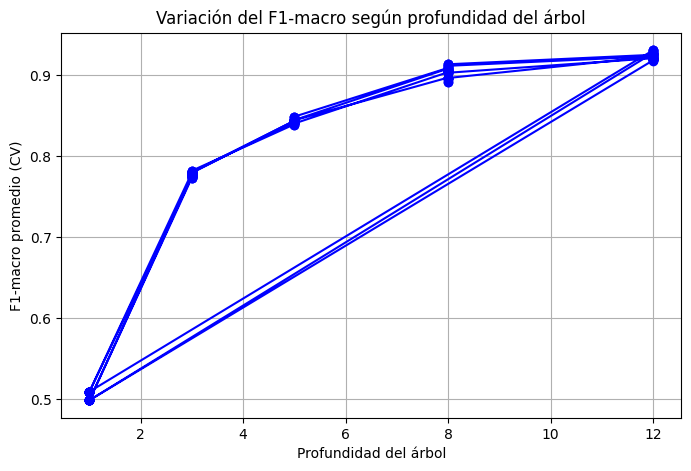

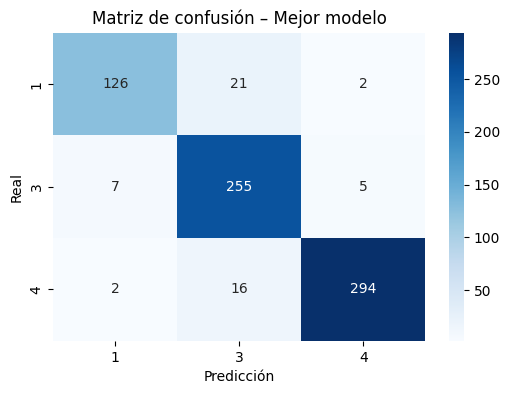


--- Desempeño del mejor modelo ---
F1-macro (Entrenamiento): 0.9470
F1-macro (Test): 0.9196
F2-score Train: 0.9451722411569721
F2-score Test: 0.9161108199191217

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           1       0.93      0.85      0.89       149
           3       0.87      0.96      0.91       267
           4       0.98      0.94      0.96       312

    accuracy                           0.93       728
   macro avg       0.93      0.91      0.92       728
weighted avg       0.93      0.93      0.93       728



In [53]:
#Hacemos diccionario con hiperparametros
param_grid = {'max_depth': [1, 3, 5, 8, 12],        # controla complejidad
    'min_samples_split': [2, 5, 10],         # evita sobreajuste
    'min_samples_leaf': [1, 2, 5],           # evita hojas muy pequeñas
    'class_weight': [None, 'balanced'],      # útil si hay desbalance
    'criterion': ['gini', 'entropy']}        #El criterio de pureza del arbol
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1-macro (CV):", grid.best_score_)
best_dt = grid.best_estimator_
#Sacamos los resultados en un data frame
results = pd.DataFrame(grid.cv_results_)
#Graficamos el F1-score con respesto a los hiperparametros
plt.figure(figsize=(8,5))
plt.plot(results["param_max_depth"], results["mean_test_score"], marker="o", color="b")
plt.xlabel("Profundidad del árbol")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variación del F1-macro según profundidad del árbol")
plt.grid(True)
plt.show()
#Ahora mostramos la matriz de confusion
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo")
plt.show()
#Hacemos el clasification report
train_f1 = f1_score(y_train, y_pred_train, average="macro")
test_f1  = f1_score(y_test,  y_pred_test,  average="macro")
print("\n--- Desempeño del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
f2 = fbeta_score(y_train, y_pred_train, beta=2, average='macro')
print("F2-score Train:", f2)
f22 = fbeta_score(y_test, y_pred_test, beta=2, average='macro')
print("F2-score Test:", f22)
print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test))


##2.1.4 BONO - Word Embeddings con  SVM

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


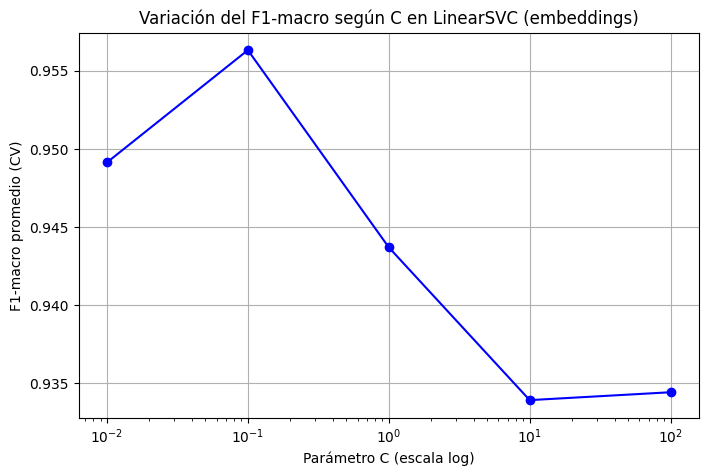

Mejores hiperparámetros: {'svm__C': 0.1}
Mejor F1-macro (CV): 0.9563182799311534

--- Desempeño del mejor modelo ---
F1-macro (Entrenamiento): 0.9857
F1-macro (Test): 0.9539

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           1       0.95      0.91      0.93       149
           3       0.96      0.96      0.96       267
           4       0.96      0.98      0.97       312

    accuracy                           0.96       728
   macro avg       0.96      0.95      0.95       728
weighted avg       0.96      0.96      0.96       728



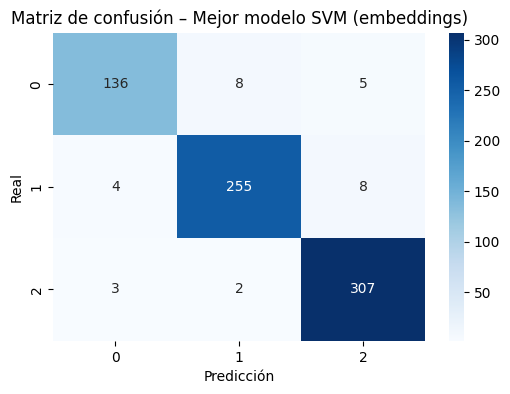

In [54]:
from sklearn.base import TransformerMixin

# partition on raw text
X_train_bono, X_test_bono, y_train_bono, y_test_bono = train_test_split(
    X_raw, y, test_size=0.3, random_state=0
)

#Transformer para embedding
class EmbeddingVectorizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectors = []
        for text in X:
            doc = nlp.make_doc(str(text))  # just tokenize, no parser/tagger
            # collect vectors for tokens that actually have embeddings
            word_vecs = [token.vector for token in doc if token.has_vector]
            if word_vecs:
                vectors.append(np.mean(word_vecs, axis=0))
            else:
                vectors.append(np.zeros(nlp.vocab.vectors_length))
        return np.array(vectors, dtype="float32")

# Definimos pipeline ---
svm = LinearSVC(random_state=0, max_iter=5000)
pipeline = Pipeline([
    ("embeddings", EmbeddingVectorizer()),
    ("svm", svm)
])

# Hiperparámetros a explorar ---
param_grid = {"svm__C": [0.01, 0.1, 1, 10, 100]}
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# GridSearch con validación cruzada ---
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train_bono, y_train_bono)

# Resultados en DataFrame ---
results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8,5))
plt.plot(results["param_svm__C"], results["mean_test_score"], marker="o", color="b")
plt.xscale("log")
plt.xlabel("Parámetro C (escala log)")
plt.ylabel("F1-macro promedio (CV)")
plt.title("Variación del F1-macro según C en LinearSVC (embeddings)")
plt.grid(True)
plt.show()

# Mejor modelo encontrado ---
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Mejor F1-macro (CV):", best_score)

# Evaluación en train y test ---
best_svm = grid.best_estimator_
y_pred_train = best_svm.predict(X_train_bono)
y_pred_test = best_svm.predict(X_test_bono)

train_f1 = f1_score(y_train_bono, y_pred_train, average="macro")
test_f1 = f1_score(y_test_bono, y_pred_test, average="macro")

print("\n--- Desempeño del mejor modelo ---")
print(f"F1-macro (Entrenamiento): {train_f1:.4f}")
print(f"F1-macro (Test): {test_f1:.4f}")
print("\nReporte de clasificación (Test):")
print(classification_report(y_test_bono, y_pred_test))

# Matriz de confusión ---
cm = confusion_matrix(y_test_bono, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo SVM (embeddings)")
plt.show()

Los resultados obtenidos muestran que el modelo SVM utilizando representaciones con word embeddings alcanzó un desempeño muy sólido. El mejor valor del hiperparámetro
𝐶
C fue 0.1, con un F1-macro promedio en validación cruzada de aproximadamente 0.956. Esto refleja que el modelo logra un buen equilibrio entre sesgo y varianza, evitando tanto el sobreajuste como el subajuste. Además, la curva de desempeño muestra que valores muy bajos o muy altos de
𝐶
C reducen la capacidad del clasificador para generalizar adecuadamente, confirmando que el ajuste fino de este parámetro es esencial para el rendimiento óptimo.

En la evaluación sobre los conjuntos de entrenamiento y prueba, se observa una alta consistencia: el F1-macro en entrenamiento fue de 0.9857 y en prueba de 0.9539. Esta cercanía entre ambas métricas indica que el modelo generaliza correctamente y no está sobreajustado a los datos de entrenamiento. El reporte de clasificación confirma este hallazgo, con valores de precisión, recall y F1-score muy equilibrados entre las tres clases, alcanzando una exactitud global del 96%. La matriz de confusión refuerza esta conclusión, ya que la mayoría de las instancias son clasificadas correctamente, con muy pocos errores de asignación entre clases.



## 2.2 Selección del modelo

Al analizar los resultados de los tres algoritmos, nos fijamos que el SVM obtuvo las mejores metricas . Con un recall entre el 95% y 98%, presicion entre 95% y 97% y el f1-score entre 95% y 98% lo que lo hace el modelo mas óptimo :)


**Entrenamiento y Validación**

Después de usar GridSearchCV, encontramos que el mejor hiperparámetro para el SVM fue:

{'C': 100}


Con este valor se entrenó el modelo en el conjunto de entrenamiento y luego se evaluó con el conjunto de validación (10% de los datos originales).

In [55]:
# 1. Entrenamiento con mejor hiperparámetro
best_svm = LinearSVC(random_state=0, max_iter=5000, C=100)
best_svm.fit(X_train, y_train)

LinearSVC(C=100, max_iter=5000, random_state=0)

**¿Por qué era necesaria la partición?**

Recordemos que la partición de datos se realizó en tres set train -> test -> validation.

- Entrenamiento (Train):
En esta partición (70% de los datos), el modelo aprende los patrones de los textos y ajusta sus parámetros internos. Aquí no evaluamos desempeño, porque el modelo ya "vio" estos datos y sería engañoso.

- Evaluación inicial (Test – 20% de los datos):
El conjunto de prueba es la evaluación principal. Nos permite medir qué tan bien el modelo generaliza a datos que no fueron usados en el entrenamiento.
Además, con esta se calcula la matriz de confusión y métricas como precisión, recall y F1 para CADA UNO DE LOS MODELOS. Realmente, es la métrica de referencia para comparar modelos.

- Validación final (Validation – 10% de los datos):
Este conjunto funciona como una segunda capa de verificación.

En conclusión, el test nos da confianza en el modelo, la validación nos permite contrastar estabilidad y robustez.
Si el modelo mantiene un desempeño similar en validation, significa que no está sobreajustado y tiene buena capacidad de generalización.

In [56]:
# 2. Evaluación en VALIDATION
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
y_val_pred = best_svm.predict(X_val)

val_metrics = {
    "F1-macro": f1_score(y_val, y_val_pred, average="macro"),
    "Balanced Accuracy": balanced_accuracy_score(y_val, y_val_pred),
    "Cohen’s Kappa": cohen_kappa_score(y_val, y_val_pred)
}

val_report = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).T
display(pd.DataFrame([val_metrics]).T.rename(columns={0:"Validation"}).style.background_gradient(cmap="Blues"))
display(val_report.style.background_gradient(cmap="Greens"))

,Validation
F1-macro,0.967043
Balanced Accuracy,0.966369
Cohen’s Kappa,0.950437


,precision,recall,f1-score,support
1,0.966102,0.957983,0.962025,119.000000
3,0.966019,0.966019,0.966019,206.000000
4,0.971074,0.975104,0.973085,241.000000
accuracy,0.968198,0.968198,0.968198,0.968198
macro avg,0.967732,0.966369,0.967043,566.000000
weighted avg,0.968189,0.968198,0.968188,566.000000


Gracias a las métricas del set de validación, notamos que el modelo mantiene un desempeño estable y muy alto, confirmando que no hubo sobreajuste respecto al conjunto de prueba.

El Cohen’s Kappa > 0.95 muestra una altísima concordancia entre las predicciones y las etiquetas reales, lo cual valida la robustez del clasificador.

El Balanced Accuracy ≈ 0.97 indica que el modelo trata a todas las clases de manera equitativa, sin favorecer a la clase mayoritaria.

Las métricas por clase muestran un rendimiento especialmente fuerte en ODS 4 (Educación), con recall de 0.975, lo que significa que casi todos los textos de este ODS son correctamente detectados.

Las ligeras confusiones siguen dándose en ODS 1 (Pobreza), donde el recall fue un poco más bajo (0.958), lo cual tiene sentido dado el solapamiento semántico con otros ODS.

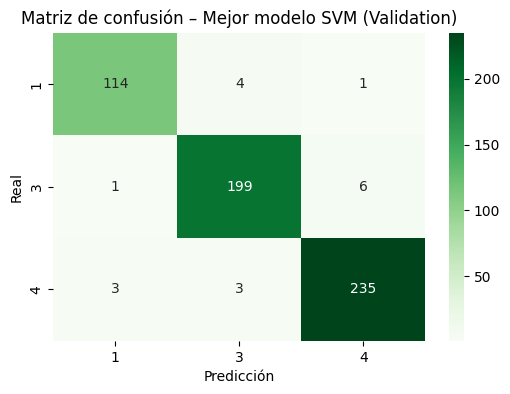

In [57]:
# 5. Matriz de confusión (  DE VALIDATION)
conf_mat_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_val, annot=True, fmt="d", cmap="Greens",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – Mejor modelo SVM (Validation)")
plt.show()

**Contraste con el test**

A continuación, mostraremos las mismas métricas aplicadas pero al set de test.

In [58]:
# 3. Evaluación en TEST
y_test_pred = best_svm.predict(X_test)

test_metrics = {
    "F1-macro": f1_score(y_test, y_test_pred, average="macro"),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_test_pred),
    "Cohen’s Kappa": cohen_kappa_score(y_test, y_test_pred)
}

test_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
display(pd.DataFrame([test_metrics]).T.rename(columns={0:"Test"}).style.background_gradient(cmap="Blues"))
display(test_report.style.background_gradient(cmap="Greens"))

,Test
F1-macro,0.962201
Balanced Accuracy,0.961960
Cohen’s Kappa,0.946315


,precision,recall,f1-score,support
1,0.946309,0.946309,0.946309,149.000000
3,0.969697,0.958801,0.964218,267.000000
4,0.971429,0.980769,0.976077,312.000000
accuracy,0.965659,0.965659,0.965659,0.965659
macro avg,0.962478,0.961960,0.962201,728.000000
weighted avg,0.965652,0.965659,0.965635,728.000000


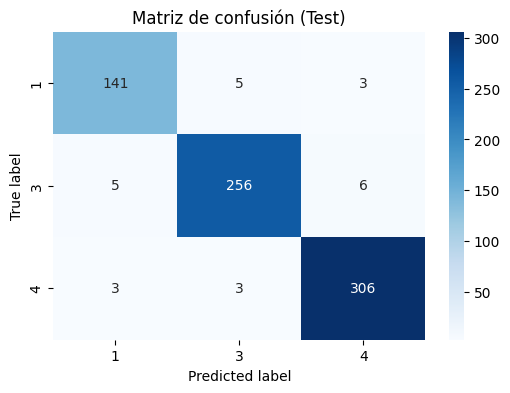

In [59]:
# 4. Matriz de confusión De TEST
conf_mat = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Matriz de confusión (Test)")
plt.show()

Se muestra que ambos conjuntos muestran resultados muy consistentes (diferencias menores a 0.01 en las métricas), lo que confirma que el modelo no depende de una partición específica de los datos.

En Test, el modelo alcanzó un F1-macro de 0.962, con excelente desempeño en todas las clases.

En Validation, las métricas incluso mejoraron ligeramente (F1-macro de 0.967), lo cual indica buena capacidad de generalización.

La métrica de Cohen’s Kappa > 0.94 en ambos casos demuestra una concordancia muy fuerte entre predicciones y etiquetas reales.

En las métricas por clase:

ODS 1 (Pobreza): es la clase más desafiante, con un recall de 0.946 en Test y 0.958 en Validación.

ODS 3 (Salud) y ODS 4 (Educación): muestran un desempeño balanceado y superior al 0.96 en F1.

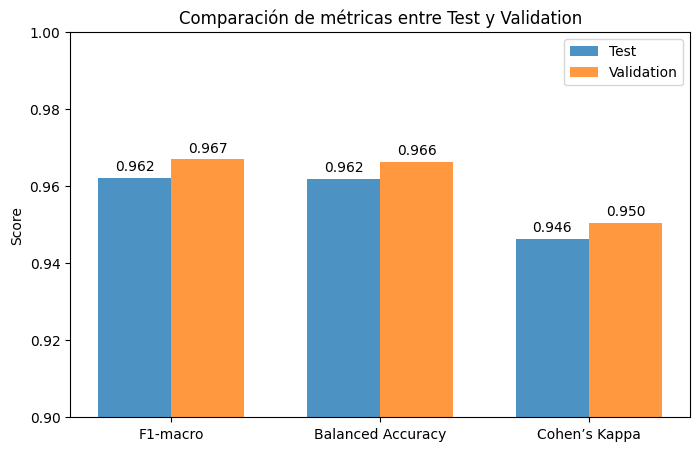

In [60]:
# Métricas de Test
test_scores = {
    "F1-macro": 0.962201,
    "Balanced Accuracy": 0.961960,
    "Cohen’s Kappa": 0.946315
}

# Métricas de Validation
val_scores = {
    "F1-macro": 0.967043,
    "Balanced Accuracy": 0.966369,
    "Cohen’s Kappa": 0.950437
}

# Preparar datos
metrics = list(test_scores.keys())
test_vals = list(test_scores.values())
val_vals = list(val_scores.values())
x = np.arange(len(metrics))
width = 0.35

# Graficar
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, test_vals, width, label="Test", alpha=0.8)
bars2 = ax.bar(x + width/2, val_vals, width, label="Validation", alpha=0.8)

# Etiquetas y estilo
ax.set_ylabel("Score")
ax.set_title("Comparación de métricas entre Test y Validation")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.9, 1.0)
ax.legend()

# Mostrar valores encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

## Análisis palabras clave

Adicionalmente, veremos el top de las palabras usadas para la clasificación de cada clase para evidenciar si hay lógica o tiene sentido.

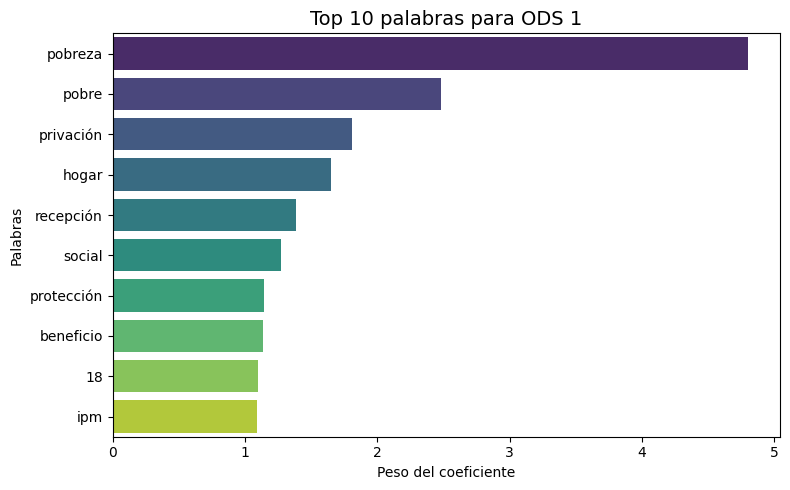

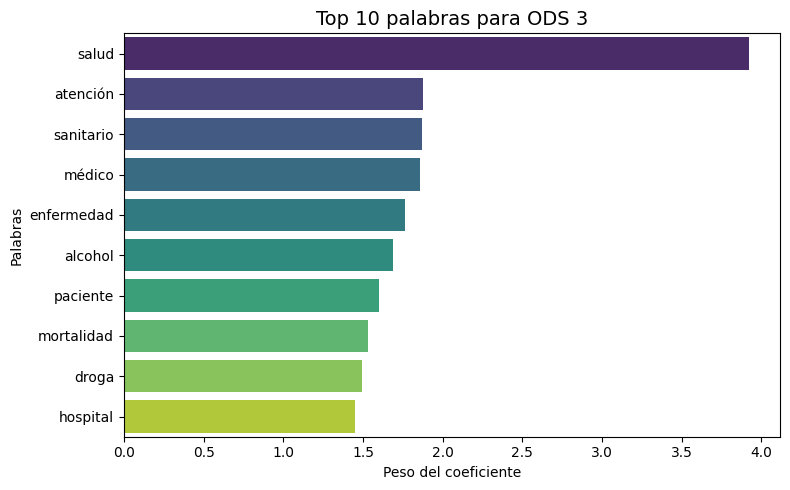

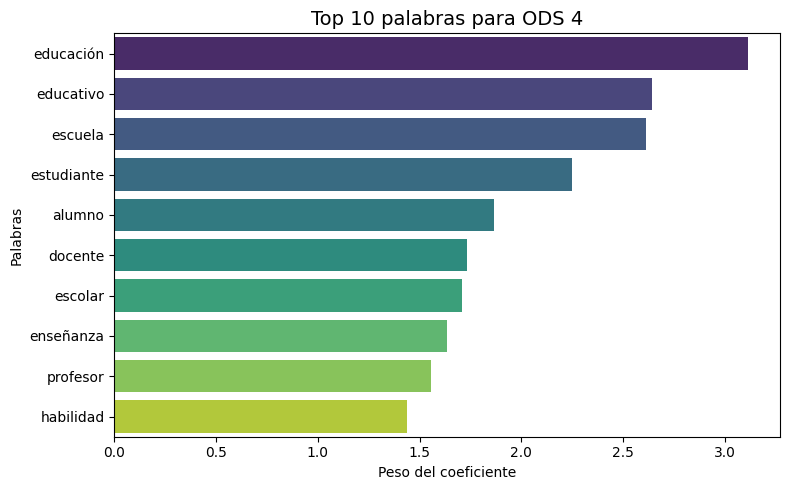

In [61]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = best_svm.coef_

def plot_top_words_separadas(coefs, feature_names, top_n=10):
    for i, class_label in enumerate(best_svm.classes_):
        top_indices = np.argsort(coefs[i])[-top_n:]
        top_features = [(feature_names[j], coefs[i][j]) for j in reversed(top_indices)]
        palabras, pesos = zip(*top_features)

        plt.figure(figsize=(8, 5))
        sns.barplot(
            x=pesos,
            y=palabras,
            hue=palabras,
            palette="viridis",
            dodge=False,
            legend=False
        )
        plt.title(f"Top {top_n} palabras para ODS {class_label}", fontsize=14)
        plt.xlabel("Peso del coeficiente")
        plt.ylabel("Palabras")
        plt.tight_layout()
        plt.show()

plot_top_words_separadas(coefs, feature_names, top_n=10)

El análisis de las palabras más representativas para cada ODS permite identificar de manera clara los temas y preocupaciones que la ciudadanía asocia con cada objetivo. En el caso del ODS 1 (Fin de la pobreza), términos como pobreza, privación, hogar o protección evidencian que las opiniones se centran en las carencias básicas y en la necesidad de políticas de protección social. Esto indica que la organización debe fortalecer sus estrategias de apoyo a hogares vulnerables y programas de transferencia de beneficios, lo cual responde directamente a las demandas identificadas en los textos analizados.

Para el ODS 3 (Salud y bienestar), la presencia de palabras como salud, atención, médico, enfermedad o hospital refleja la importancia que los ciudadanos atribuyen al acceso a servicios médicos de calidad y a la atención sanitaria en general. Esta información puede orientar a la organización a diseñar campañas enfocadas en la promoción de hábitos saludables, prevención de enfermedades y mejora de la infraestructura hospitalaria. Asimismo, la mención de alcohol y droga sugiere la necesidad de políticas públicas más sólidas en torno a la salud mental y las adicciones.

En cuanto al ODS 4 (Educación de calidad), palabras como educación, escuela, docente, profesor y estudiante ponen de relieve que la ciudadanía relaciona este objetivo con la calidad del sistema educativo y la formación de los actores que participan en él. De esta manera, la organización podría priorizar estrategias para mejorar las competencias de los docentes, garantizar el acceso equitativo a la educación y fomentar habilidades que preparen a los estudiantes para los retos sociales y laborales.

En conjunto, estos resultados muestran que el análisis de lenguaje natural no solo permite clasificar automáticamente las opiniones en función de los ODS, sino también identificar con precisión los temas clave que deben ser abordados. Para la organización, esta información resulta valiosa porque facilita la toma de decisiones basadas en evidencia y permite diseñar políticas y estrategias focalizadas que respondan directamente a las percepciones y necesidades expresadas por la población.

## Conclusiones del mejor modelo (SVC)

- El SVM lineal con C=100 se consolidó como el mejor modelo, alcanzando F1-macro ≈ 0.96–0.97 en Test y Validation.

- La coherencia entre ambos conjuntos confirma que el modelo no está sobreajustado y es robusto para nuevos datos.

- El equilibrio entre precisión y recall lo hace adecuado para clasificación automática de textos en los ODS 1, 3 y 4, minimizando falsos positivos y negativos de forma equitativa.

- Este contraste entre Test y Validation demuestra que el modelo no solo funciona bien en la fase de prueba, sino que también mantiene su calidad predictiva en escenarios reales.

## 2.3 Dataset de test

In [62]:
# Entrenar en el conjunto de entrenamiento
best_model = LinearSVC(random_state=0, max_iter=5000, C=100)
best_model.fit(X_train, y_train)

# Evaluar en validación
y_val_pred = best_model.predict(X_val)
print("F1-macro (Validación):", f1_score(y_val, y_val_pred, average='macro'))
print("\nReporte de clasificación (Validación):")
print(classification_report(y_val, y_val_pred))

F1-macro (Validación): 0.9670432066865963

Reporte de clasificación (Validación):
              precision    recall  f1-score   support

           1       0.97      0.96      0.96       119
           3       0.97      0.97      0.97       206
           4       0.97      0.98      0.97       241

    accuracy                           0.97       566
   macro avg       0.97      0.97      0.97       566
weighted avg       0.97      0.97      0.97       566



In [63]:
#Carga de datos para el de prueba
prueba = pd.read_excel("Datos de prueba_proyecto.xlsx")
print(prueba.head())

                                      Textos_espanol
0  El rector, que es el representante local del M...
1  Tenga en cuenta que todos los programas antipo...
2  Debido a que son en gran medida invisibles, es...
3  Los recursos aún son limitados en este sector....
4  Durante el período 1985-2008, la educación pri...


In [64]:
prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  152 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


In [65]:
#Hacemos el analisis de calidad de los datos
# Valores nulos por columna
print("Valores nulos:\n", prueba.isnull().sum())

# Filas duplicadas
print("\nNúmero de filas duplicadas:", prueba.duplicated().sum())

# Longitud de los textos
prueba["longitud_texto"] = prueba["Textos_espanol"].astype(str).apply(len)

print("\nEstadísticas de longitud de textos:")
print(prueba["longitud_texto"].describe())

# Detectar textos muy cortos
print("\nTextos con menos de 10 caracteres:")
print(prueba[prueba["longitud_texto"] < 10].head())

Valores nulos:
 Textos_espanol    0
dtype: int64

Número de filas duplicadas: 0

Estadísticas de longitud de textos:
count     152.000000
mean      677.638158
std       218.683798
min       340.000000
25%       521.000000
50%       619.500000
75%       817.500000
max      1298.000000
Name: longitud_texto, dtype: float64

Textos con menos de 10 caracteres:
Empty DataFrame
Columns: [Textos_espanol, longitud_texto]
Index: []


In [66]:
#Se realiza un cambio en la funcion lemmatize_text ya que necesitamos una Funcion Transformadora para que
#pueda realzar el proceso de automatizacion
def lemmatize_batch(X):
    s = pd.Series(X).astype(str)
    out = []
    for doc in nlp.pipe(s.tolist(), batch_size=64, disable=["ner"]):
        out.append(" ".join([t.lemma_ for t in doc if not t.is_punct and not t.is_stop]))
    return np.array(out)
# Luego se aplica la vectoriacion (TF-IDF) para revisar las palabras mas repetidas
prueba_processed = vectorizer.transform(lemmatize_batch(prueba["Textos_espanol"]))
# Definimos el Pipeline con el mejor modelo SVM
pipeline = Pipeline([
    ("classifier", LinearSVC(random_state=0, max_iter=5000))
])


# Fitting el pipeline
pipeline.fit(X_train, y_train)


# Se hace las predicciones
y_pred = pipeline.predict(prueba_processed) # Apply the pipeline directly to the raw text data


# Se muestra un print de los resultados arrojados
print("Predicciones realizadas:")
print(y_pred)

Predicciones realizadas:
[4 3 1 3 4 3 4 4 4 3 4 4 1 4 4 3 4 4 1 3 4 3 3 3 1 1 3 1 4 1 4 3 4 3 3 4 3
 4 4 4 4 4 1 3 3 3 3 4 3 4 3 4 3 4 4 4 1 4 1 4 1 4 1 1 3 3 1 3 4 3 3 3 4 4
 3 3 3 4 1 1 1 4 4 1 4 4 4 3 4 4 1 4 4 4 1 4 4 3 4 4 4 4 3 3 3 1 3 1 3 1 4
 3 3 3 3 3 3 1 3 3 3 1 3 3 3 1 1 1 3 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


# Exportación de resultados

In [67]:
# Agregamos la nueva columna
prueba["ODS"] = y_pred

# guardamos el Excel con los resultados
prueba.to_excel("Predicciones_ODS.xlsx", index=False)

print("DataFrame guardado en  'Predicciones_ODS.xlsx'")

DataFrame guardado en  'Predicciones_ODS.xlsx'
